In [1]:
%load_ext autoreload
%autoreload 2


import pandas as pd
from glob import glob
from os import path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('notebook')

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

from mythicwind.csv_io import read_frame
from mythicwind.ellipse import *

%matplotlib notebook

from IPython.display import display, Markdown, Latex

def print_md(string):
    display(Markdown(string))

def print_ltx(string):
    display(Latex(string))
    
def plot_blade_landing(helihoist, sbitroot, sbittip, first_contact, blade_landing, save_fig_path=None, ylim=(-0.1, 0.1)):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(16,9))

    ax1.plot(helihoist.deflection, label='helihoist')
    ax1.plot(sbitroot.deflection, label='sbitroot')
    ax1.plot(sbittip.deflection, label='sbittip')
    ax1.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax1.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax1.legend(ncol=4, loc='lower right')
    ax1.set_ylabel('deflection (m)')

    ax2.set_ylim([-0.1, 0.1])
    ax2.plot(sbitroot.deflection - helihoist.deflection, label='sbitroot - helihoist', color='tab:orange')
    ax2.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax2.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax2.axhline(y=0, color='k')
    ax2.legend(loc='upper right', ncol=2)
    ax2.set_ylabel('deflection diff (m)')

    ax3.set_ylim([-0.1, 0.1])
    ax3.plot(sbittip.deflection - helihoist.deflection, label='sbittip - helihoist', color='tab:green')
    ax3.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax3.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax3.axhline(y=0, color='k')
    ax3.legend(loc='upper right', ncol=2)
    ax3.set_ylabel('deflection diff (m)')

    ax4.set_ylim([-0.1, 0.1])
    ax4.plot(sbitroot.deflection - sbittip.deflection, label='sbitroot - sbittip', color='lightblue')
    ax4.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax4.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax4.axhline(y=0, color='k')
    ax4.legend(loc='upper right', ncol=2)
    ax4.set_ylabel('deflection diff (m)')
    ax4.set_xlabel('date / time')
    
    if save_fig_path:
        fig.savefig(save_fig_path, dpi=300)
    
def plot_blade_landing_geometry(helihoist, sbitroot, sbittip, first_contact, blade_landing, resample_window='50ms', rolling_window='1min', save_fig_path=None, ylim=(-0.1, 0.1)):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(16,9))

    ax1.plot(helihoist.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='helihoist')
    ax1.plot(sbitroot.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='sbitroot')
    ax1.plot(sbittip.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='sbittip')
    ax1.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax1.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax1.legend(ncol=4, loc='lower right')
    ax1.set_ylabel('deflection (m)')

    ax2.set_ylim([-0.1, 0.1])
    ax2.plot(sbitroot.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean() - helihoist.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='sbitroot - helihoist', color='tab:orange')
    ax2.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax2.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax2.axhline(y=0, color='k')
    ax2.legend(loc='upper right', ncol=2)
    ax2.set_ylabel('deflection diff (m)')

    ax3.set_ylim([-0.1, 0.1])
    ax3.plot(sbittip.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean() - helihoist.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='sbittip - helihoist', color='tab:green')
    ax3.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax3.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax3.axhline(y=0, color='k')
    ax3.legend(loc='upper right', ncol=2)
    ax3.set_ylabel('deflection diff (m)')

    ax4.set_ylim([-0.1, 0.1])
    ax4.plot(sbitroot.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean() - sbittip.max_deflection.resample(resample_window).mean().rolling(rolling_window).mean(), label='sbitroot - sbittip', color='lightblue')
    ax4.axvline(x=blade_landing, color='tab:red', label='blade landing')
    ax4.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
    ax4.axhline(y=0, color='k')
    ax4.legend(loc='upper right', ncol=2)
    ax4.set_ylabel('deflection diff (m)')
    ax4.set_xlabel('date / time')
    
    if save_fig_path:
        fig.savefig(save_fig_path, dpi=300)



In [2]:
data_dir = '../data/turbines/turbine-12/'
blade_landing = pd.to_datetime('2019-11-05 4:48:50', utc=True)
first_contact=pd.to_datetime('2019-11-5 04:16', utc=True)
sbi_deltaT = pd.to_timedelta(2, unit='h')
start = blade_landing - sbi_deltaT
stop = blade_landing + sbi_deltaT
print(start, blade_landing, stop)

2019-11-05 02:48:50+00:00 2019-11-05 04:48:50+00:00 2019-11-05 06:48:50+00:00


In [3]:
data = defaultdict(list)
for pos in ('helihoist-1', 'sbittip', 'sbitroot'):
    pos_dir = path.join(data_dir, pos)
    if path.isdir(pos_dir):
        print(f'\n\nprocessing {pos_dir}')
        pos_data = path.join(pos_dir, 'tom/acc-vel-pos')
        if path.isdir(pos_data):
            for tomfile in sorted(glob(path.join(pos_data, '*.csv'))):                
                # parse the date of the file first
                file_start = pd.to_datetime(tomfile.split('/')[-1].split('_')[4], format='%Y-%m-%d-%H-%M-%S', utc=True)
                file_stop = pd.to_datetime(tomfile.split('/')[-1].split('_')[5].split('.')[0], format='%Y-%d-%m-%H-%M-%S', utc=True)
                if file_start > start:
                    if file_start < stop:
                        print(f'found file {tomfile}')
                        data[pos].append(read_frame(tomfile))

helihoist = pd.concat(data['helihoist-1'])
sbitroot = pd.concat(data['sbitroot'])
sbittip = pd.concat(data['sbittip'])
del(data)



processing ../data/turbines/turbine-12/helihoist-1
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-03-21-56_2019-11-05-03-57-37.csv
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-03-57-37_2019-11-05-04-33-05.csv
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-04-33-05_2019-11-05-05-08-37.csv
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-05-08-37_2019-11-05-05-44-09.csv
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-05-44-09_2019-11-05-06-19-41.csv
found file ../data/turbines/turbine-12/helihoist-1/tom/acc-vel-pos/turbine-12_helihoist-1_tom_acc-vel-pos_2019-11-05-06-19-41_2019-11-05-06-55-15.csv


processing ../data/turbines/turbine-12/sbitti

In [5]:
helihoist_geometry_df = geometry_analysis(helihoist)
sbittip_geometry_df = geometry_analysis(sbittip)
sbitroot_geometry_df = geometry_analysis(sbitroot)

viewing plane normal vector: [ 0.        0.       -0.019728]
viewing plane normal vector: [-0.        0.        0.004532]
omitting last element
viewing plane normal vector: [-0.        0.       -0.002021]


<IPython.core.display.Javascript object>


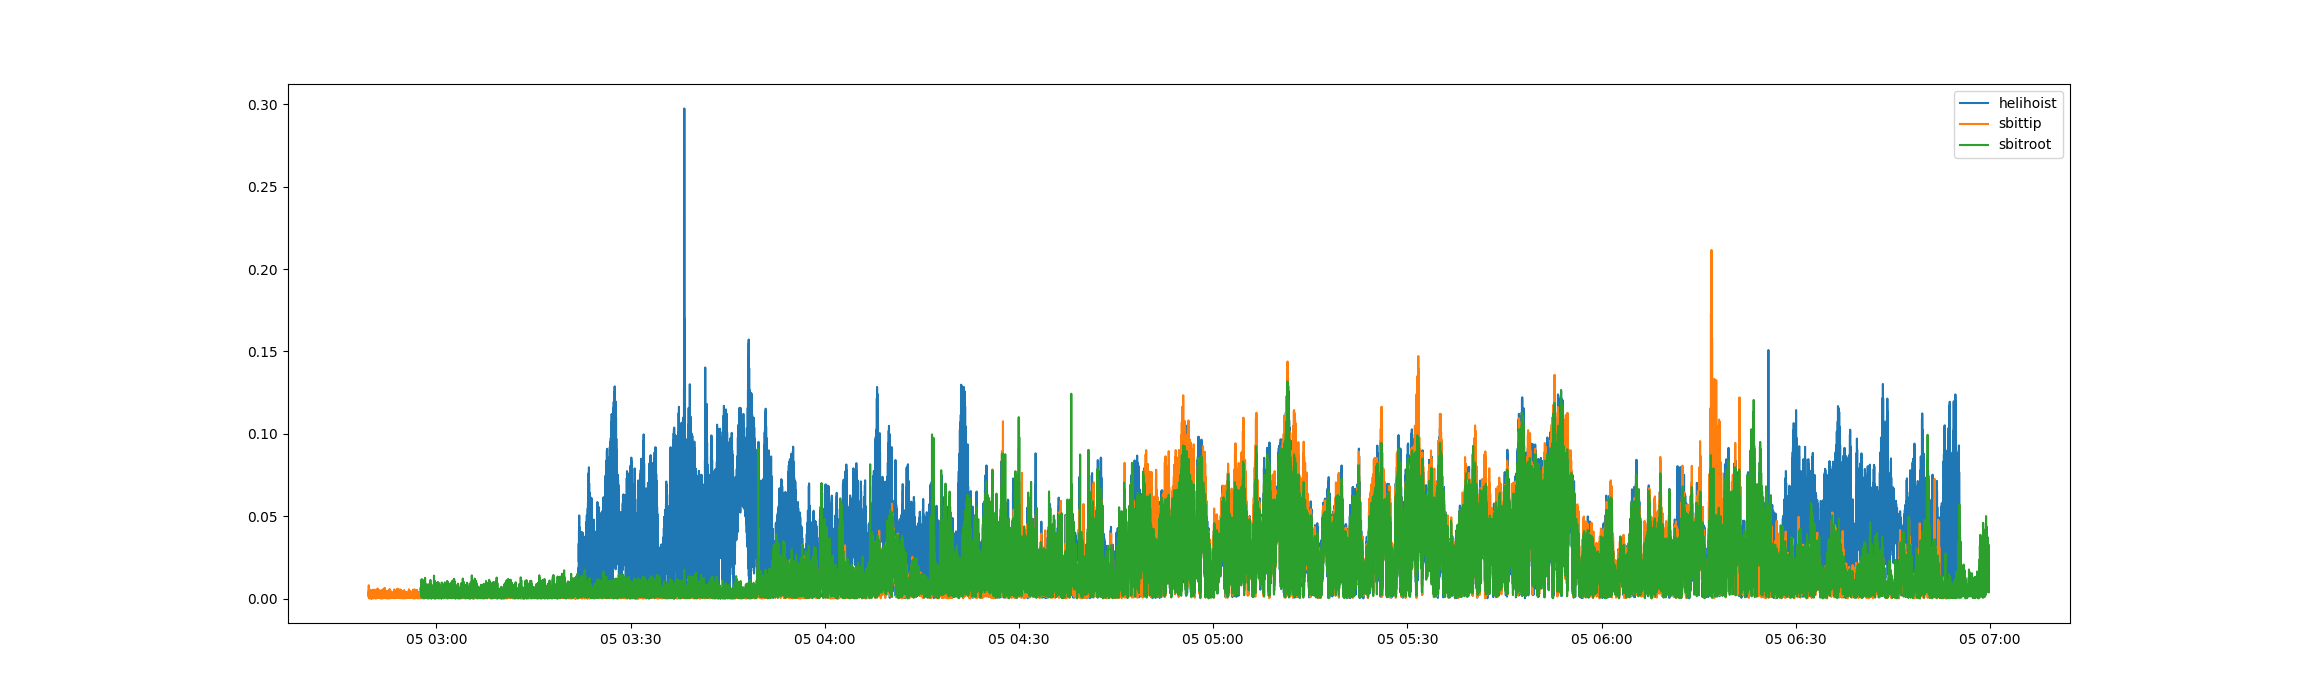

In [7]:
plt.figure(figsize=(23, 7))
plt.plot(helihoist.deflection, label='helihoist')
plt.plot(sbittip.deflection, label='sbittip')
plt.plot(sbitroot.deflection, label='sbitroot')
plt.legend()

<IPython.core.display.Javascript object>


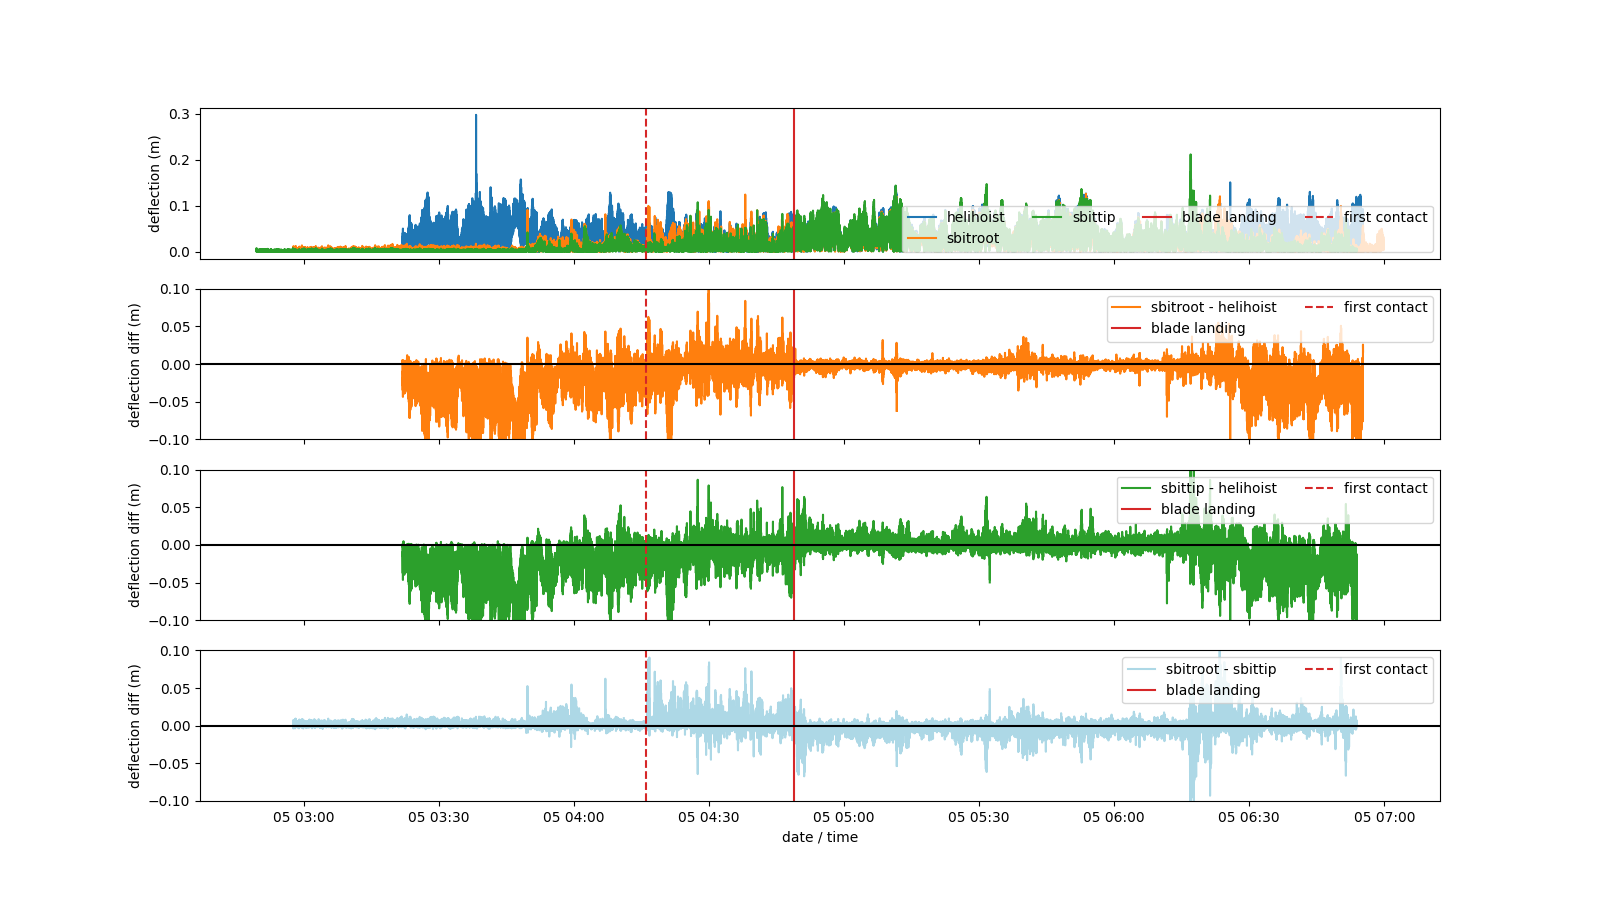

In [101]:
plot_blade_landing(helihoist=helihoist, sbitroot=sbitroot, sbittip=sbittip, first_contact=first_contact, blade_landing=blade_landing, save_fig_path='../results/turbine-12/deflections-bladelanding.png')

<IPython.core.display.Javascript object>


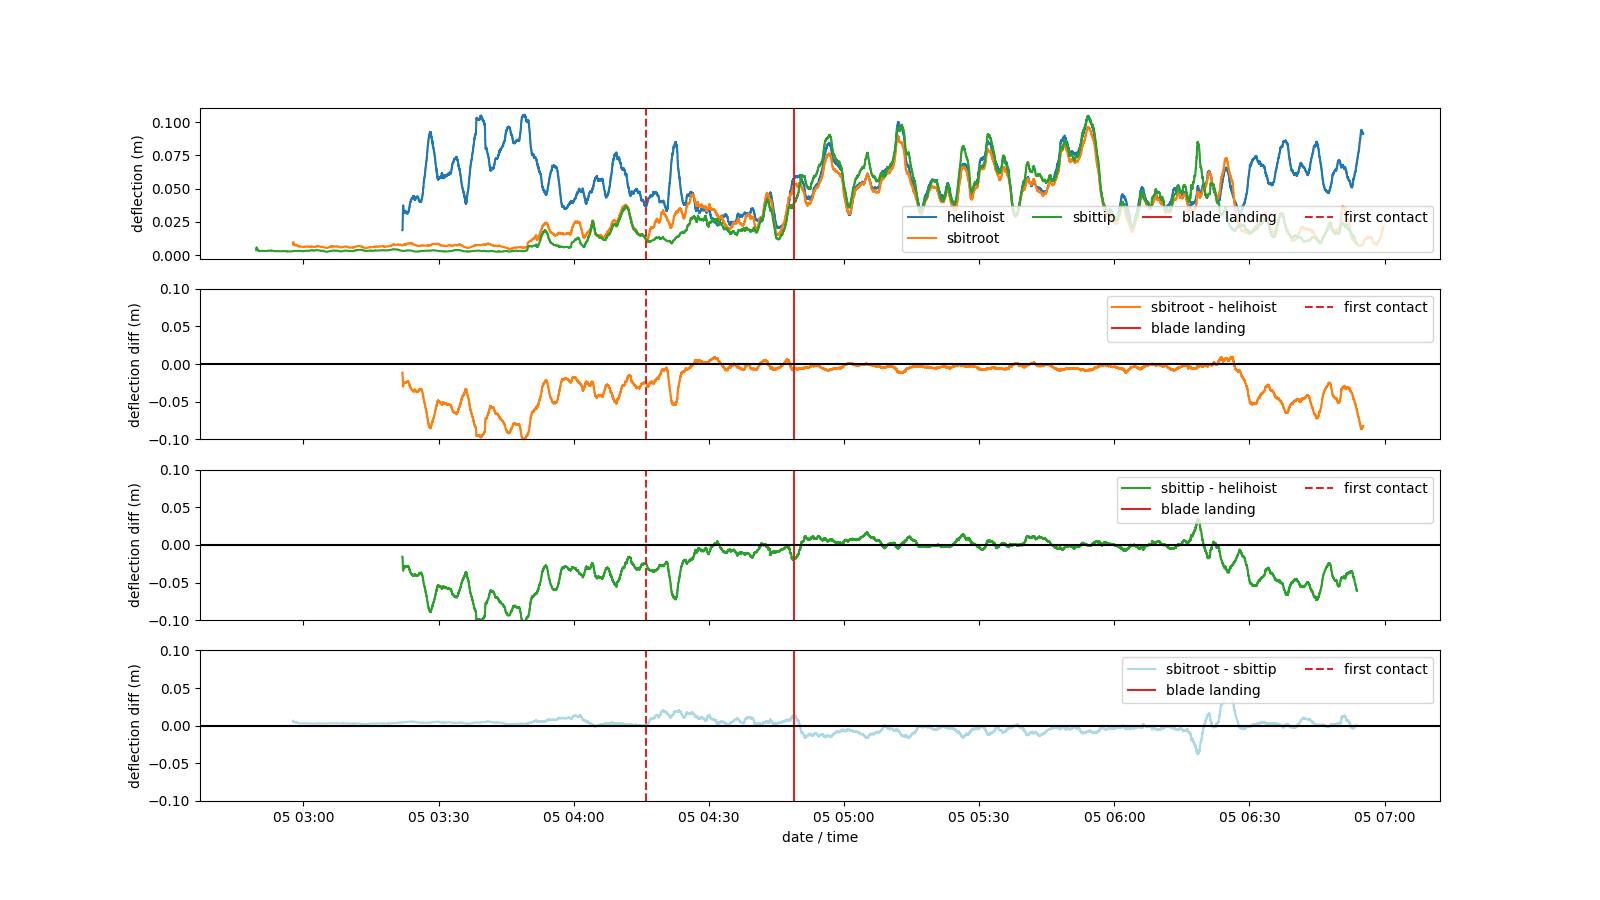

In [102]:
plot_blade_landing_geometry(helihoist=helihoist_geometry_df, sbitroot=sbitroot_geometry_df, sbittip=sbittip_geometry_df, first_contact=first_contact, blade_landing=blade_landing, resample_window='33ms', rolling_window='2min', save_fig_path='../results/turbine-12/deflections-bladelanding-smooth.png')

<IPython.core.display.Javascript object>


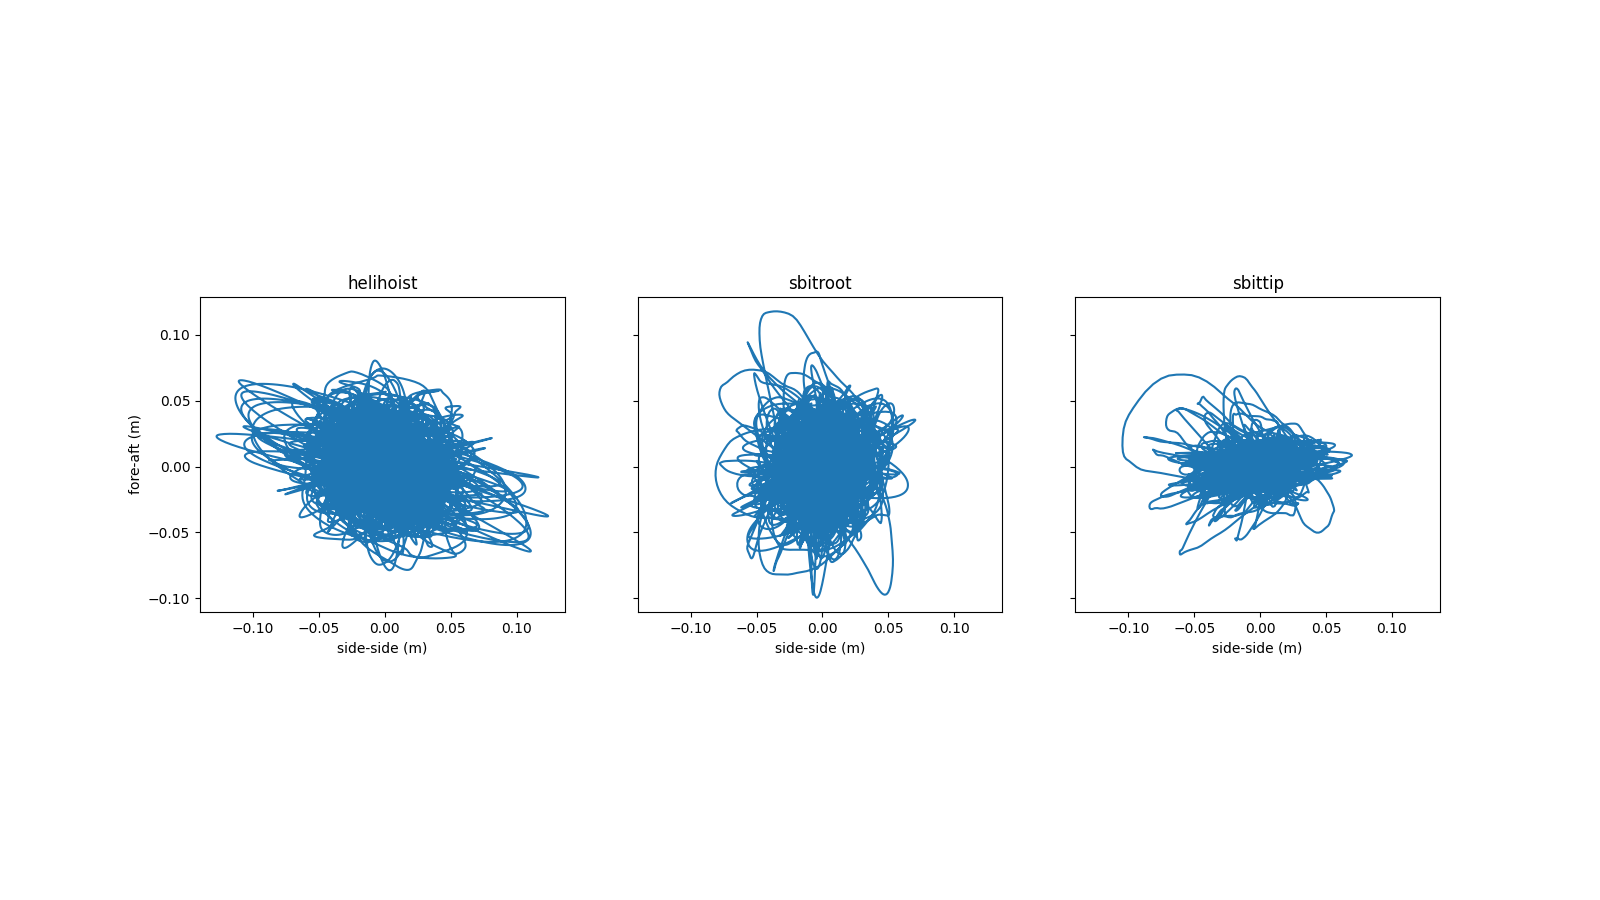

In [8]:
t1 = blade_landing - pd.to_timedelta(1, unit='hour')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(16,9))
ax1.set_aspect('equal', 'box')
ax1.set_title('helihoist')
ax1.set_ylabel('fore-aft (m)')
ax1.set_xlabel('side-side (m)')
ax1.plot(helihoist[first_contact:blade_landing].pos_z, helihoist[first_contact:blade_landing].pos_x)
ax2.set_aspect('equal', 'box')
ax2.set_title('sbitroot')
ax2.set_xlabel('side-side (m)')
ax2.plot(sbitroot[first_contact:blade_landing].pos_z, sbitroot[first_contact:blade_landing].pos_x)
ax3.set_aspect('equal', 'box')
ax3.set_title('sbittip')
ax3.set_xlabel('side-side (m)')
ax3.plot(sbittip[first_contact:blade_landing].pos_z, sbittip[first_contact:blade_landing].pos_x)
fig.savefig('../results/turbine-12/turbine-12_bladelanding_orbits.png', dpi=300)

## Orbit Ellipses

<IPython.core.display.Javascript object>


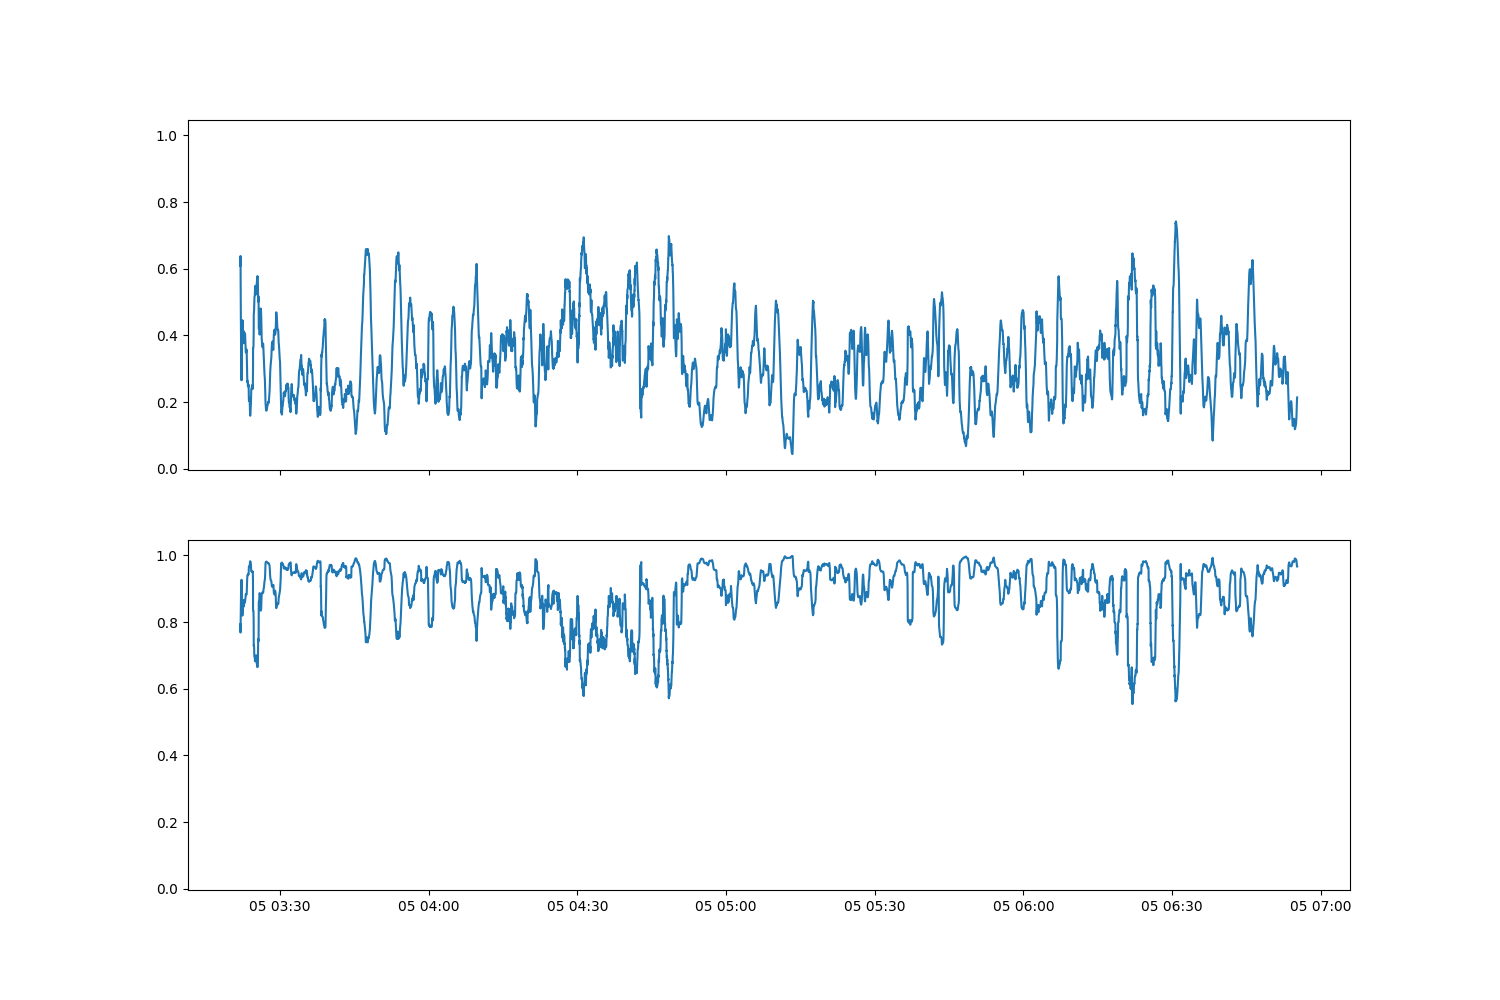

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15, 10))
ax1.plot(helihoist_geometry_df.axis_ratio.rolling('1min').mean())
ax2.plot(helihoist_geometry_df.eccentricity.rolling('1min').mean())


<IPython.core.display.Javascript object>


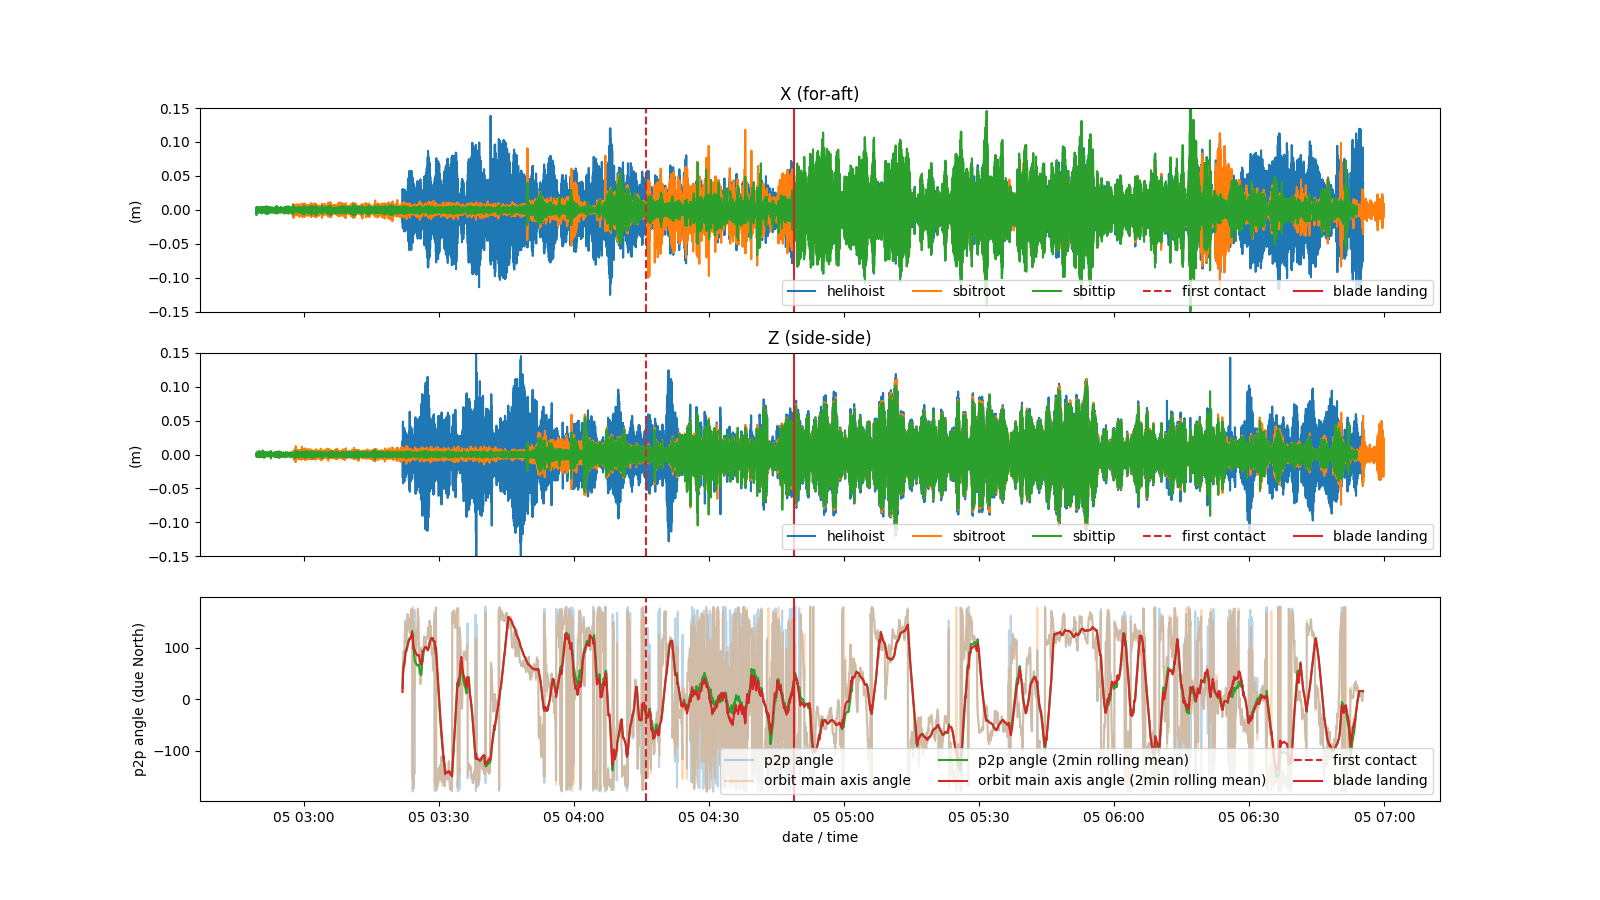

In [104]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(16, 9))

ax1.plot(helihoist.pos_x, label='helihoist')
ax1.plot(sbitroot.pos_x, label='sbitroot')
ax1.plot(sbittip.pos_x, label='sbittip')
ax1.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
ax1.axvline(x=blade_landing, color='tab:red', label='blade landing')
ax1.set_title('X (for-aft)')
ax1.set_ylim([-0.15, 0.15])
ax1.set_ylabel('(m)')
ax1.legend(ncol=5, loc='lower right')

ax2.plot(helihoist.pos_z, label='helihoist')
ax2.plot(sbitroot.pos_z, label='sbitroot')
ax2.plot(sbittip.pos_z, label='sbittip')
ax2.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
ax2.axvline(x=blade_landing, color='tab:red', label='blade landing')
ax2.set_title('Z (side-side)')
ax2.set_ylim([-0.15, 0.15])
ax2.set_ylabel('(m)')
ax2.legend(ncol=5, loc='lower right')


ax3.plot(helihoist_geometry_df.p2p_angle, alpha=0.3, label='p2p angle')
ax3.plot(helihoist_geometry_df.axis_angle[::2], alpha=0.3, label='orbit main axis angle')
ax3.plot(helihoist_geometry_df.p2p_angle.rolling('2min').mean(), label='p2p angle (2min rolling mean)')
ax3.plot(helihoist_geometry_df.axis_angle[::2].rolling('2min').mean(), label='orbit main axis angle (2min rolling mean)')
ax3.axvline(x=first_contact, color='tab:red', linestyle='--', label='first contact')
ax3.axvline(x=blade_landing, color='tab:red', label='blade landing')
ax3.set_ylabel('p2p angle (due North)')
ax3.legend(ncol=3, loc='lower right')
ax3.set_xlabel('date / time')

fig.savefig('../results/turbine-12/directionality.png', dpi=300)

## Distribution of data prior to blade landing

In [62]:
t1 = blade_landing - pd.to_timedelta(1, unit='h')
t2 = blade_landing

<IPython.core.display.Javascript object>


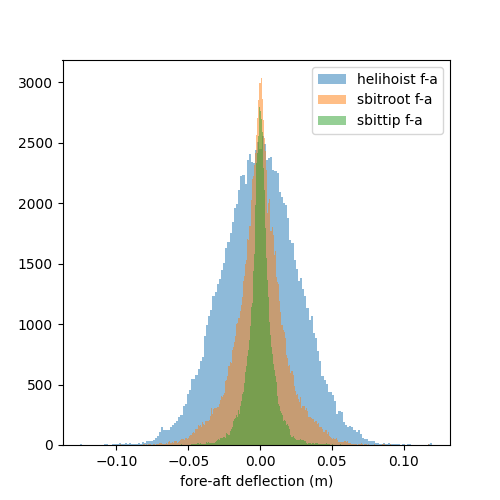

In [98]:
N = len(helihoist.pos_x)

plt.figure(figsize=(5,5))
plt.hist(helihoist.pos_x[t1:t2], bins='fd', alpha=0.5, label='helihoist f-a')
plt.hist(sbitroot.pos_x[t1:t2], bins='fd', alpha=0.5, label='sbitroot f-a')
plt.hist(sbittip.pos_x[t1:t2], bins='fd', alpha=0.5, label='sbittip f-a')
plt.legend()
plt.xlabel('fore-aft deflection (m)')
plt.savefig('../results/turbine-12/fore-aft_deflection-distribution.png', dpi=300)

<IPython.core.display.Javascript object>


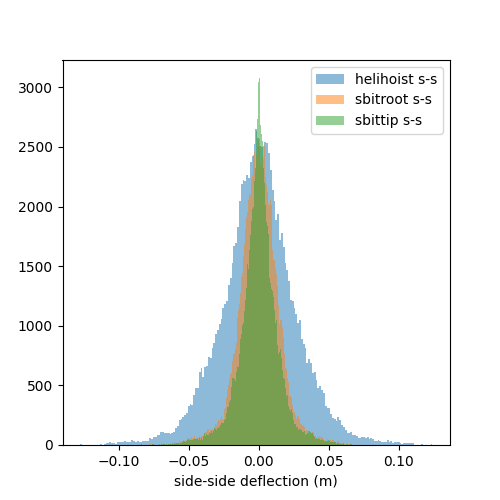

In [97]:
plt.figure(figsize=(5,5))
plt.hist(helihoist.pos_z[t1:t2], bins='fd', alpha=0.5, label='helihoist s-s')
plt.hist(sbitroot.pos_z[t1:t2], bins='fd', alpha=0.5, label='sbitroot s-s')
plt.hist(sbittip.pos_z[t1:t2], bins='fd', alpha=0.5, label='sbittip s-s')
plt.legend()
plt.xlabel('side-side deflection (m)')
plt.savefig('../results/turbine-12/side-side_deflection-distribution.png', dpi=300)

<IPython.core.display.Javascript object>


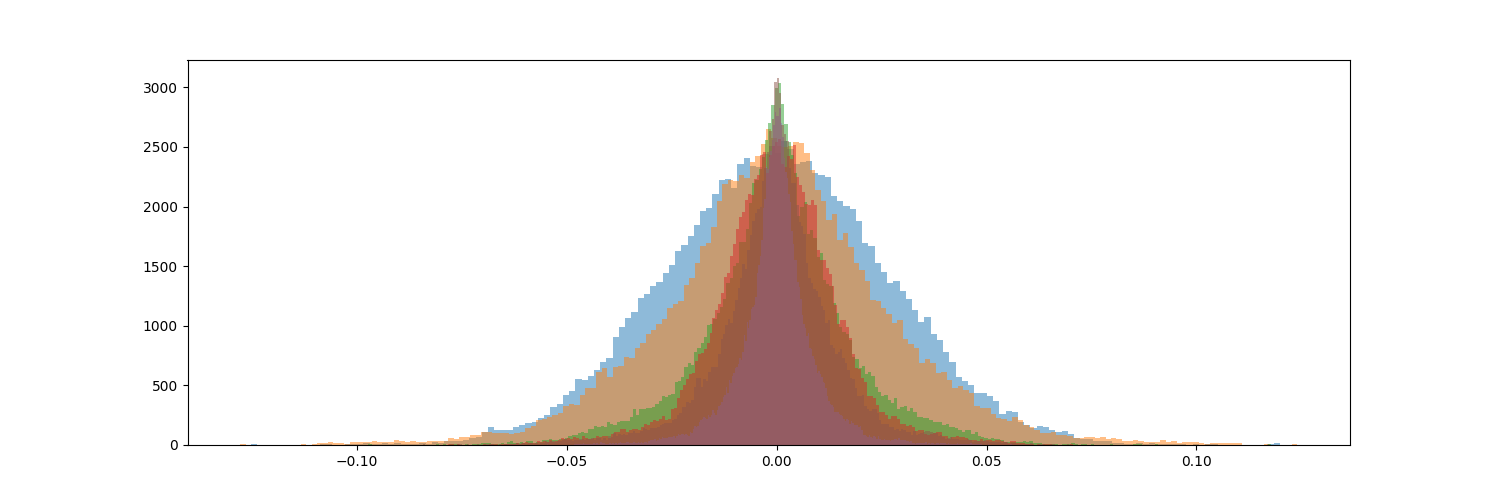

''

In [66]:
plt.figure()
plt.hist(helihoist.pos_x[t1:t2], bins='fd', alpha=0.5)
plt.hist(helihoist.pos_z[t1:t2], bins='fd', alpha=0.5)
plt.hist(sbitroot.pos_x[t1:t2], bins='fd', alpha=0.5)
plt.hist(sbitroot.pos_z[t1:t2], bins='fd', alpha=0.5)
plt.hist(sbittip.pos_x[t1:t2], bins='fd', alpha=0.5)
plt.hist(sbittip.pos_z[t1:t2], bins='fd', alpha=0.5)
;

<IPython.core.display.Javascript object>


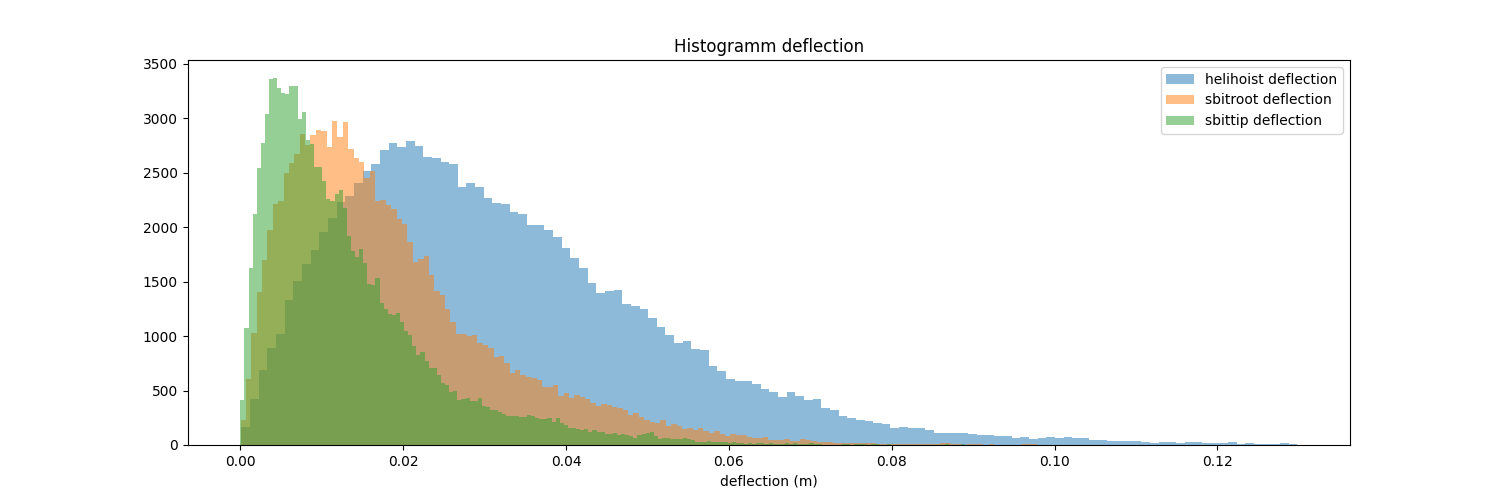

In [99]:
plt.figure()
plt.title('Histogramm deflection')
plt.hist(helihoist.deflection[t1:t2], bins='fd', alpha=0.5, label='helihoist deflection')
plt.hist(sbitroot.deflection[t1:t2], bins='fd', alpha=0.5, label='sbitroot deflection')
plt.hist(sbittip.deflection[t1:t2], bins='fd', alpha=0.5, label='sbittip deflection')
plt.xlabel('deflection (m)')
plt.legend()
plt.savefig('../results/turbine-12/deflection-distribution.png', dpi=300)

<IPython.core.display.Javascript object>


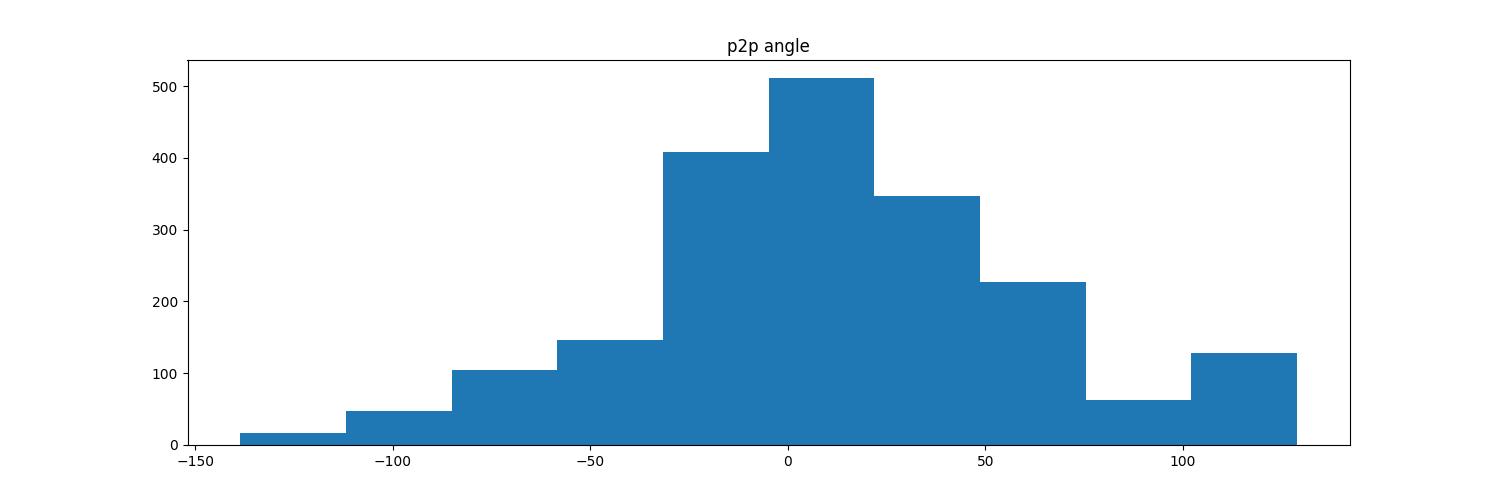

<IPython.core.display.Javascript object>


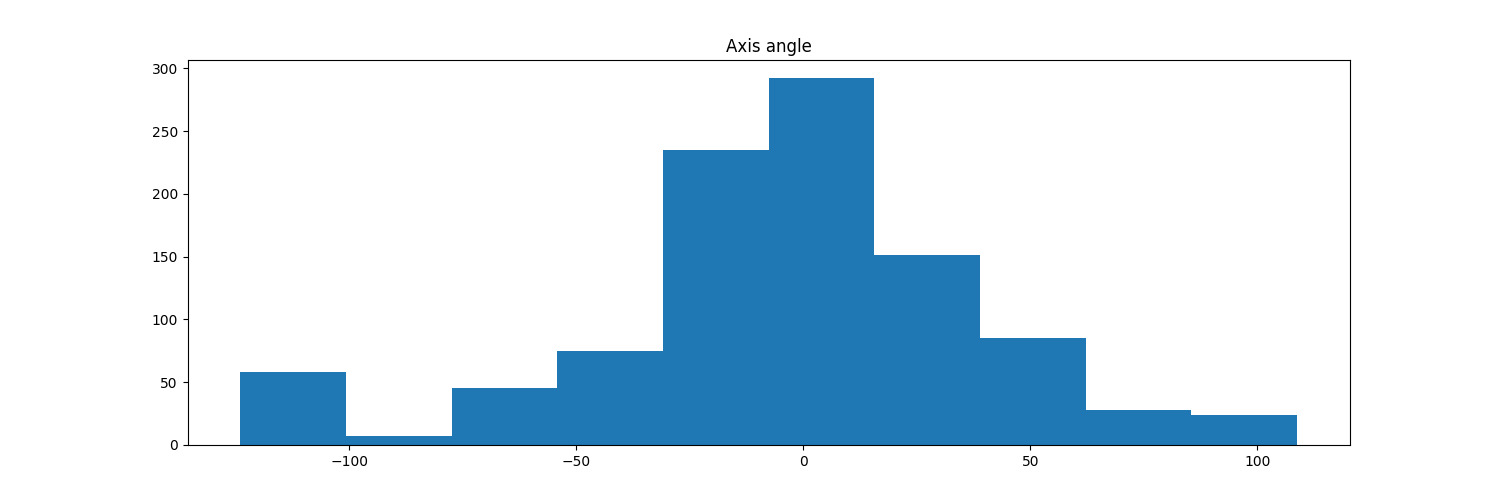

(array([ 58.,   7.,  45.,  75., 235., 292., 151.,  85.,  28.,  24.]),
 array([-123.96986136, -100.69502891,  -77.42019647,  -54.14536402,
         -30.87053158,   -7.59569913,   15.67913331,   38.95396576,
          62.2287982 ,   85.50363065,  108.77846309]),
 <a list of 10 Patch objects>)

In [71]:
plt.figure()
plt.title('p2p angle')
plt.hist(helihoist_geometry_df[t1:t2].p2p_angle.rolling('2min').mean())
plt.figure()
plt.title('Axis angle')
plt.hist(helihoist_geometry_df[t1:t2].axis_angle[::2].rolling('2min').mean())